In [1]:
import torch
from torch import nn
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights
from torchsummary import summary
import os
from torchvision import datasets, transforms
import random 
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from tqdm.auto import tqdm

In [2]:
resnet18_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [4]:
gpu = 0
# Check if specified GPU is available, else default to CPU
if torch.cuda.is_available():
    try:
        device = torch.device(f"cuda:{gpu}")
        # Test if the specified GPU index is valid
        _ = torch.cuda.get_device_name(device)
    except AssertionError:
        print(f"GPU {gpu} is not available. Falling back to GPU 0.")
        device = torch.device("cuda:0")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

In [5]:
resnet18_model = resnet18_model.to(device)

In [6]:
resnet18_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
resnet18_model.eval()  # switch to eval mode
summary(resnet18_model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [7]:

data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [8]:
train_data_path = "/data2/users/koushani/chbmit/CT_scan_ML/Data/train"
test_data_path = "/data2/users/koushani/chbmit/CT_scan_ML/Data/test"
validation_data_path = "/data2/users/koushani/chbmit/CT_scan_ML/Data/valid"

In [9]:
train_data = datasets.ImageFolder(root=train_data_path, transform=data_transform)
test_data = datasets.ImageFolder(root=test_data_path, transform=data_transform)
validation_data = datasets.ImageFolder(root=validation_data_path, transform=data_transform)

In [10]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")
print(f"Number of validation samples: {len(validation_data)}")

Number of training samples: 613
Number of test samples: 315
Number of validation samples: 72


In [11]:
torch.set_printoptions(threshold=torch.inf)
data_item = test_data[100]
print(data_item)

(tensor([[[0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0039, 0.0314, 0.0706, 0.0549, 0.0392, 0.0392,
          0.0275, 0.0118, 0.0039, 0.0078, 0.0039, 0.0039, 0.0039, 0.0039,
          0.0000, 0.0078, 0.0275, 0.0471, 0.0549, 0.0667, 0.0667, 0.0667,
          0.0510, 0.0353, 0.0196, 0.0078, 0.0039, 0.0039, 0.0078, 0.0118,
          0.0235, 0.0431, 0.0627, 0.0667, 0.0706, 0.0627, 0.0667, 0.0627,
          0.0627, 0.0627, 0.0588, 0.0588, 0.0471, 0.0392, 0.0431, 0.0549,
          0.0588, 0.0510, 0.0471, 0.0392, 0.0353, 0.0235, 0.0235, 0.0471,
          0.0627, 0.0588, 0.0431, 0.0275, 0.0039, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0039, 0.0

In [12]:
class_names = train_data.classes
class_names

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [14]:
# Change the key
old_key1 = 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
new_key1 = 'adenocarcinoma_left.lower.lobe'

old_key2 = 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
new_key2 = 'large.cell.carcinoma_left.hilum'

old_key3 = 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
new_key3 = 'squamous.cell.carcinoma_left.hilum'

# Step 1: Add new key-value pair
class_dict[new_key1] = class_dict[old_key1]
class_dict[new_key2] = class_dict[old_key2]
class_dict[new_key3] = class_dict[old_key3]


# Step 2: Remove old key-value pair
del class_dict[old_key1]
del class_dict[old_key2]
del class_dict[old_key3]


print(class_dict)

{'normal': 2, 'adenocarcinoma_left.lower.lobe': 0, 'large.cell.carcinoma_left.hilum': 1, 'squamous.cell.carcinoma_left.hilum': 3}


In [15]:
class_names[0]=new_key1
class_names[1]=new_key2
class_names[3]=new_key3
class_names

['adenocarcinoma_left.lower.lobe',
 'large.cell.carcinoma_left.hilum',
 'normal',
 'squamous.cell.carcinoma_left.hilum']

In [16]:
random_idx = torch.randint(0, len(train_data), size=(1,)).item()
img, label = train_data[random_idx][0], train_data[random_idx][1]

print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
print(f"class name: {class_names[label]}")

Image tensor:
 tensor([[[0.0000, 0.0000, 0.0118, 0.0667, 0.0431, 0.0667, 0.1882, 0.3647,
          0.3725, 0.3647, 0.3608, 0.3647, 0.3647, 0.3647, 0.3647, 0.3647,
          0.3608, 0.3608, 0.3608, 0.3647, 0.3647, 0.3608, 0.3608, 0.3647,
          0.3647, 0.3647, 0.3608, 0.3647, 0.3686, 0.3882, 0.3843, 0.3765,
          0.3843, 0.4235, 0.4353, 0.4353, 0.4392, 0.4392, 0.4353, 0.4314,
          0.4314, 0.4314, 0.4353, 0.4353, 0.4314, 0.4314, 0.4314, 0.4235,
          0.4275, 0.4314, 0.4353, 0.4353, 0.4275, 0.4157, 0.4039, 0.3922,
          0.3765, 0.3647, 0.3647, 0.3686, 0.3765, 0.4000, 0.4157, 0.3608,
          0.2902, 0.1059, 0.0078, 0.0039, 0.0039, 0.0039, 0.0000, 0.0039,
          0.0118, 0.0314, 0.0353, 0.0941, 0.1765, 0.2510, 0.3255, 0.3804,
          0.4118, 0.4078, 0.3843, 0.3765, 0.3608, 0.3608, 0.3608, 0.3608,
          0.3647, 0.3647, 0.3647, 0.3647, 0.3647, 0.3608, 0.3569, 0.3647,
          0.3608, 0.3608, 0.3647, 0.3569, 0.3647, 0.3765, 0.3922, 0.4039,
          0.4078, 0.372

Image permute: torch.Size([128, 128, 3]) 


Text(0.5, 1.0, 'squamous.cell.carcinoma_left.hilum')

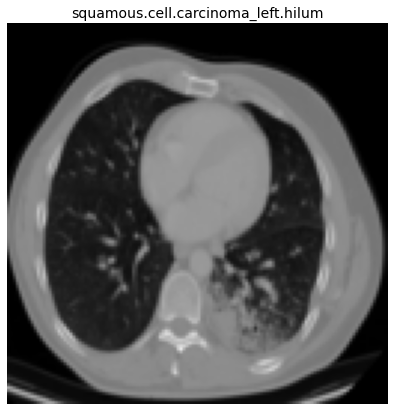

In [17]:
index = 500
img, label = train_data[index][0], train_data[index][1]


img_permute = img.permute(1, 2, 0)
print(f"Image permute: {img_permute.shape} ")
plt.figure(figsize=(12, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [18]:
BATCH_SIZE=32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f38ec4287f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f38ec428ee0>)

In [19]:
resnet18_model.fc = nn.Sequential (
    nn.Linear(512,512),
    nn.Dropout(0.2),
     nn.Linear(512,256),
    nn.Linear(256,len(class_names)), # -> len(labels) labels according to labels
)
resnet18_model.fc

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9)

In [21]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    model = model.to(device)
    y_pred = model(X) 


    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

  
    optimizer.zero_grad()

    
    loss.backward()

  
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc 

In [22]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0,  0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader): 
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

     
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

    
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [23]:
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5, 
          device=device):
  
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  return results

In [24]:
NUM_EPOCHS = 15


# Start the timer
from timeit import default_timer as timer
start_time = timer() 

model_0_results = train(model=resnet18_model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


AttributeError: 'FloatProgress' object has no attribute 'style'